In [32]:
# Importar librerías
from deepface import DeepFace
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Cargar Labels del CSV
def load_labels(csv_path):
    df = pd.read_csv(csv_path)
    labels_dict = {}
    for _, row in df.iterrows():
        # Convertir ClipID a str antes de usar replace y luego a int
        clip_id = str(row['ClipID']).replace('.avi', '').replace('.mp4', '')
        labels_dict[clip_id] = [
            int(row['Boredom']),
            int(row['Engagement']),
            int(row['Confusion']),
            int(row['Frustration'])
        ]
    return labels_dict

In [3]:
# Extraer embeddings FaceNet
def extract_facenet_embedding(img_path):
    try:
        embedding = DeepFace.represent(img_path=img_path, model_name='Facenet', enforce_detection=False)
        return np.array(embedding[0]['embedding'])
    except Exception as e:
        print(f"Error en {img_path}: {e}")
        return None

In [ ]:
def process_dataset(frames_root_folder, labels_csv, max_videos=1250):
    labels = load_labels(labels_csv)
    X = []
    y = []

    # Obtener todas las carpetas de video
    frames_root_folder = Path(frames_root_folder)
    video_folders = list(frames_root_folder.glob("*/*"))
    print(f"Total de carpetas de video encontradas: {len(video_folders)}")

    # Limitar a los primeros `max_videos`
    video_folders = video_folders[:max_videos]
    print(f"Procesando {len(video_folders)} carpetas de video...")

    # Procesar cada carpeta de video
    for video_folder in tqdm(video_folders, desc="Procesando videos"):
        clip_id = video_folder.name

        # Verificar si el clip_id está en labels
        if clip_id not in labels:
            with open("missing_clip_ids.txt", "a") as f:
                f.write(clip_id + "\n")
            print(f"ClipID {clip_id} no encontrado en labels.")
            continue

        emotion_levels = labels[clip_id]  # lista de 4 números

        # Crear un vector one-hot de 16 posiciones
        label_vector = np.zeros(16)
        for i, level in enumerate(emotion_levels):  # i = 0 (boredom), 1 (engagement), 2 (confusion), 3 (frustration)
            index = i * 4 + level  # cada emoción tiene 4 niveles
            label_vector[index] = 1

        video_embeddings = []
        
        # Procesar los frames dentro de esta carpeta
        for frame_path in video_folder.glob("*.jpg"):
            embedding = extract_facenet_embedding(str(frame_path))
            if embedding is not None:
                video_embeddings.append(embedding)
        
        video_embedding = np.mean(video_embeddings, axis=0)
        video_embedding = np.array(video_embedding)
        
        X.append(video_embedding)
        y.append(label_vector)

    X = np.array(X)
    y = np.array(y)

    print(f"Dataset procesado: {X.shape[0]} ejemplos.")
    return X, y

In [3]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [24]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../Facenet Embeddings/Train/X_train.npy'
path_val = '../Facenet Embeddings/Val/X_val.npy'
path_test = '../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

X_train = np.mean(X_train.reshape(-1, 5, 128), axis=1)
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
# if in the first or second position exists a 1, then y is 0 and only has a shape of 1, else 1
y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

X_val = np.mean(X_val.reshape(-1, 5, 128), axis=1)
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.where((y_val[:, 3] == 1), 1, 0).reshape(-1, 1)

X_test = np.mean(X_test.reshape(-1, 5, 128), axis=1)
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.where((y_test[:, 3] == 1), 1, 0).reshape(-1, 1)

In [15]:
X_train, y_train = charge_npy(path_train)
y_train = y_train[:, 4:8]
y_train, y_train.shape

(array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
 (27405, 4))

In [16]:
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train, y_train.shape

(array([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
 (5481, 4))

In [17]:
y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

In [34]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5481, 128), (5481, 1), (1720, 128), (1720, 1), (1723, 128), (1723, 1))

In [35]:
# give me how many ones and zeros are in y_train, y_val and y_test
print("Train: ", y_train.sum(), "Val: ", y_val.sum(), "Test: ", y_test.sum())
print("Train: ", y_train.shape[0], "Val: ", y_val.shape[0], "Test: ", y_test.shape[0])
print("Train: ", y_train.shape[0] - y_train.sum(), "Val: ", y_val.shape[0] - y_val.sum(), "Test: ", y_test.shape[0] - y_test.sum())

Train:  2584 Val:  625 Test:  777
Train:  5481 Val:  1720 Test:  1723
Train:  2897 Val:  1095 Test:  946


In [ ]:
# Procesar train dataset
frames_root = "output_frames/Train"
labels_csv = "TrainLabels.csv" 
#X_train, y_train = process_dataset(frames_root, labels_csv)

Total de carpetas de video encontradas: 5481
Procesando 200 carpetas de video...


Procesando videos:  98%|█████████▊| 196/200 [04:55<00:06,  1.51s/it]


KeyboardInterrupt: 

In [ ]:
#np.save('Facenet Embeddings/Train/X_train.npy', X)
#np.save('Facenet Embeddings/Train/y_train.npy', y)

In [ ]:
frames_root_val = "output_frames/Validation"
labels_csv = "AllLabels.csv"

# Procesar dataset
X_val, y_val = process_dataset(frames_root_val, labels_csv)
#np.save('Facenet Embeddings/Val/X_val.npy', X_val)
#np.save('Facenet Embeddings/Val/y_val.npy', y_val)

Total de carpetas de video encontradas: 1720
Procesando 200 carpetas de video...


Procesando videos: 100%|██████████| 200/200 [03:56<00:00,  1.18s/it]

Dataset procesado: 200 ejemplos.


In [ ]:
frames_root_test = "output_frames/Test"
labels_csv = "AllLabels.csv"

# Procesar dataset
X_test, y_test = process_dataset(frames_root_test, labels_csv)
#np.save('Facenet Embeddings/Test/X_test.npy', X_test)
#np.save('Facenet Embeddings/Test/y_test.npy', y_test)

Total de carpetas de video encontradas: 1866
Procesando 200 carpetas de video...


Procesando videos: 100%|██████████| 200/200 [03:48<00:00,  1.14s/it]

Dataset procesado: 200 ejemplos.


In [25]:
input_layer = Input(shape=(X_train.shape[1],))

x = Dense(256, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
#model.compile(
#    optimizer=Adam(learning_rate=1e-4),
#    loss=focal_loss(gamma=2., alpha=0.75),
#    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
#)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                          

In [36]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.flatten()),
    y=y_train.flatten()
)

class_weights = {i: w for i, w in enumerate(class_weights)}

In [284]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# view zeros and ones in y_train_resampled
print("Train: ", y_train_resampled.sum(), "Val: ", y_val.sum(), "Test: ", y_test.sum())
print("Train: ", y_train_resampled.shape[0], "Val: ", y_val.shape[0], "Test: ", y_test.shape[0])
print("Train: ", y_train_resampled.shape[0] - y_train_resampled.sum(), "Val: ", y_val.shape[0] - y_val.sum(), "Test: ", y_test.shape[0] - y_test.sum())

Train:  5233 Val:  1537 Test:  1638
Train:  10466 Val:  1720 Test:  1723
Train:  5233 Val:  183 Test:  85


In [37]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/300
172/172 [==============================] - 1s 2ms/step - loss: 0.6513 - accuracy: 0.6256 - val_loss: 0.6338 - val_accuracy: 0.6395
Epoch 2/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.6254 - val_loss: 0.6350 - val_accuracy: 0.6448
Epoch 3/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6527 - accuracy: 0.6329 - val_loss: 0.6359 - val_accuracy: 0.6465
Epoch 4/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.6373 - val_loss: 0.6356 - val_accuracy: 0.6407
Epoch 5/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6421 - accuracy: 0.6287 - val_loss: 0.6351 - val_accuracy: 0.6448
Epoch 6/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6375 - val_loss: 0.6328 - val_accuracy: 0.6448
Epoch 7/300
172/172 [==============================] - 0s 2ms/step - loss: 0.6333 - accuracy: 0.6517 - val_loss: 0.6340 - val_accuracy: 0.6436

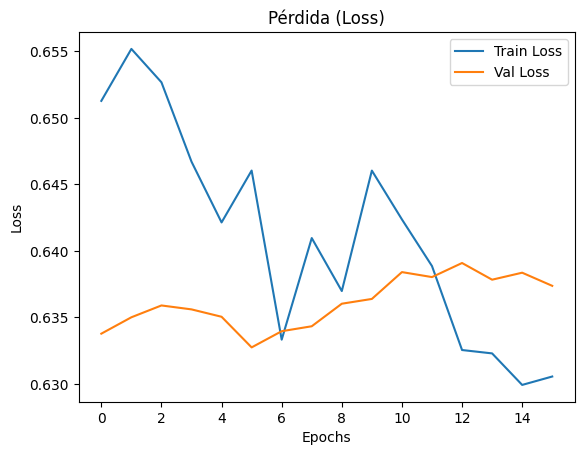

In [38]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

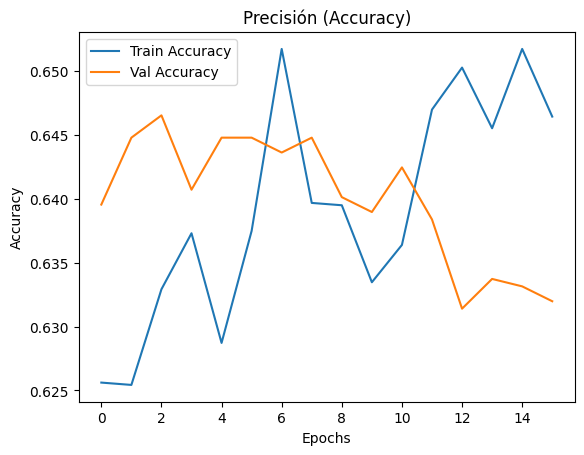

In [39]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Precisión (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

54/54 [==============================] - 0s 982us/step


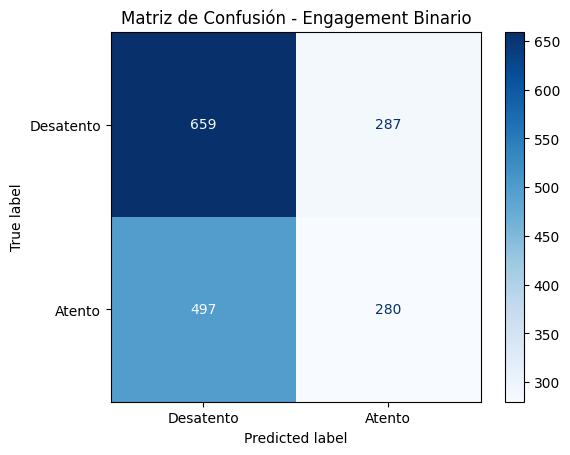

In [40]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # binarizar las probabilidades
y_true_classes = y_test.flatten()

# Matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Desatento", "Atento"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Engagement Binario")
plt.show()

In [41]:
def evaluar_engagement_binario(y_true, y_pred):
    print("Evaluación para Engagement (Binario):")
    print(classification_report(
        y_true, 
        y_pred, 
        labels=[0, 1],
        target_names=["Desatento", "Atento"]
    ))
    print("-" * 50)

# Llamada con datos de test
evaluar_engagement_binario(y_true_classes, y_pred_classes)

Evaluación para Engagement (Binario):
              precision    recall  f1-score   support

   Desatento       0.57      0.70      0.63       946
      Atento       0.49      0.36      0.42       777

    accuracy                           0.54      1723
   macro avg       0.53      0.53      0.52      1723
weighted avg       0.54      0.54      0.53      1723

--------------------------------------------------


In [42]:
# Predecimos probabilidades
y_probs = model.predict(X_test).ravel()

54/54 [==============================] - 0s 856us/step


In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculamos F1 para cada threshold
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

# Elegimos el mejor threshold
best_threshold = thresholds[np.argmax(f1)]
print(f"Mejor threshold según F1-score: {best_threshold:.4f}")

Mejor threshold según F1-score: 0.2176


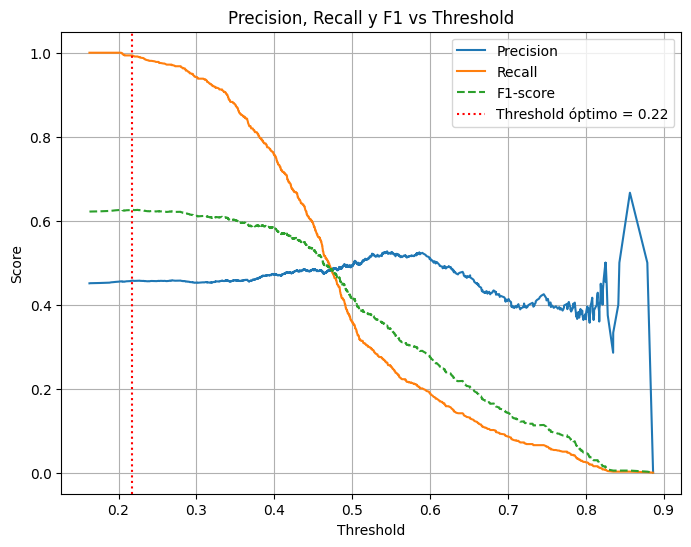

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1-score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Threshold óptimo = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted, target_names=["Desatento", "Atento"]))

              precision    recall  f1-score   support

   Desatento       0.86      0.03      0.06       946
      Atento       0.46      0.99      0.63       777

    accuracy                           0.47      1723
   macro avg       0.66      0.51      0.34      1723
weighted avg       0.68      0.47      0.32      1723



In [ ]:
## Entrada
#input_layer = Input(shape=(X_train.shape[1],))
#
## Base
#x = Dense(512, activation='relu')(input_layer)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
#
#x = Dense(128, activation='relu')(x)
#x = BatchNormalization()(x)
#
#x = Dense(64, activation='relu')(x)
#x = BatchNormalization()(x)
#
## 4 salidas
#out_boredom = Dense(4, activation='softmax', name='boredom')(x)
#out_engagement = Dense(4, activation='softmax', name='engagement')(x)
#out_confusion = Dense(4, activation='softmax', name='confusion')(x)
#out_frustration = Dense(4, activation='softmax', name='frustration')(x)
#
## Modelo final
#model = Model(inputs=input_layer, outputs=[out_boredom, out_engagement, out_confusion, out_frustration])
#
## Compilar
#model.compile(
#    optimizer='adam',
#    # Multiclass clasification loss for each output one-hot
#    loss='categorical_crossentropy',
#    metrics=['accuracy']
#)
#
#model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 512)                  66048     ['input_4[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 512)                  2048      ['dense_12[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dropout_6 (Dropout)         (None, 512)                  0         ['batch_normalization_12

In [133]:
y_boredom_train = y_train[:, 0:4]
y_engagement_train = y_train[:, 4:8]
y_confusion_train = y_train[:, 8:12]
y_frustration_train = y_train[:, 12:16]

y_boredom_val = y_val[:, 0:4]
y_engagement_val = y_val[:, 4:8]
y_confusion_val = y_val[:, 8:12]
y_frustration_val = y_val[:, 12:16]

y_boredom_test = y_test[:, 0:4]
y_engagement_test = y_test[:, 4:8]
y_confusion_test = y_test[:, 8:12]
y_frustration_test = y_test[:, 12:16]

In [134]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, [y_boredom_train, y_engagement_train, y_confusion_train, y_frustration_train],
    validation_data=(X_val, [y_boredom_val, y_engagement_val, y_confusion_val, y_frustration_val]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


AttributeError: in user code:

    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\training.py", line 1152, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\training.py", line 1246, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\compile_utils.py", line 592, in update_state
        self.build(y_pred, y_true)
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\compile_utils.py", line 498, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\compile_utils.py", line 646, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\compile_utils.py", line 646, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\code\env\Lib\site-packages\tf_keras\src\engine\compile_utils.py", line 667, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'


In [ ]:
#with open('history.pkl', 'wb') as f:
#    pickle.dump(history.history, f)
#
#model.save("model-mean.h5")
#model = models.load_model("model-all.h5")

In [ ]:
#with open('history.pkl', 'rb') as f:
#    history = pickle.load(f)

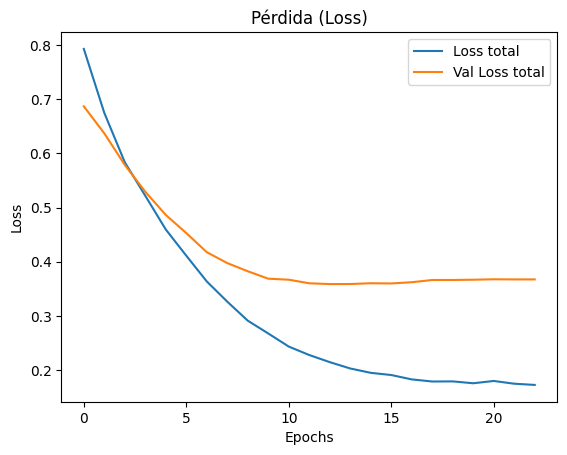

KeyError: 'boredom_accuracy'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Loss
plt.plot(history.history['loss'], label='Loss total')
plt.plot(history.history['val_loss'], label='Val Loss total')
plt.title('Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy de cada salida
plt.figure(figsize=(12, 8))
for output in ['boredom', 'engagement', 'confusion', 'frustration']:
    plt.plot(history.history[f'{output}_accuracy'], label=f'{output} train')
    plt.plot(history.history[f'val_{output}_accuracy'], label=f'{output} val')

plt.title('Accuracy de cada emoción')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

54/54 [==============================] - 0s 1ms/step


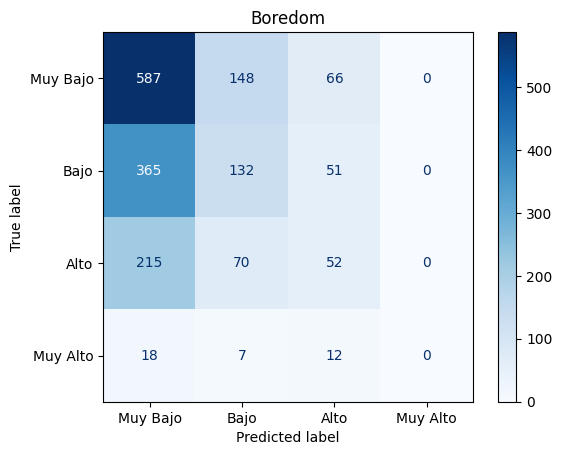

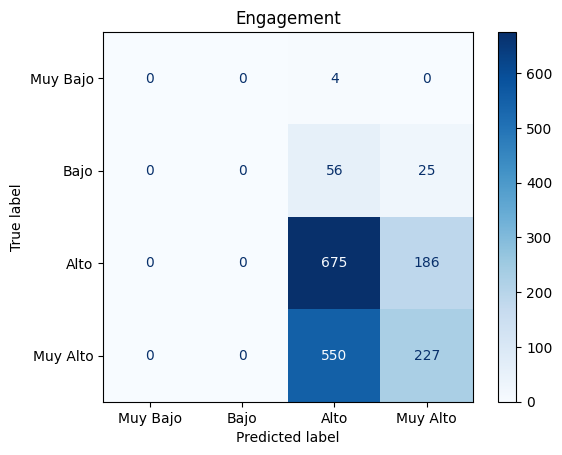

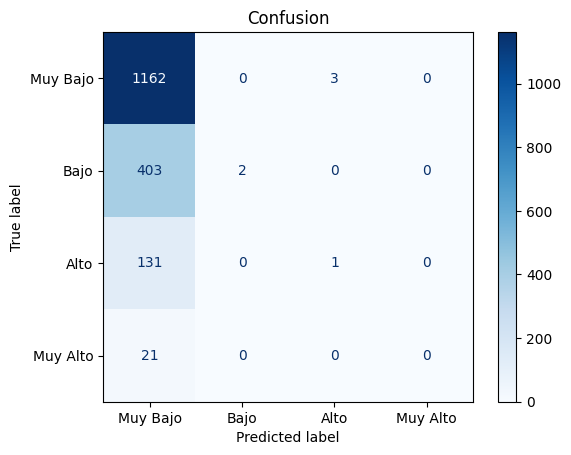

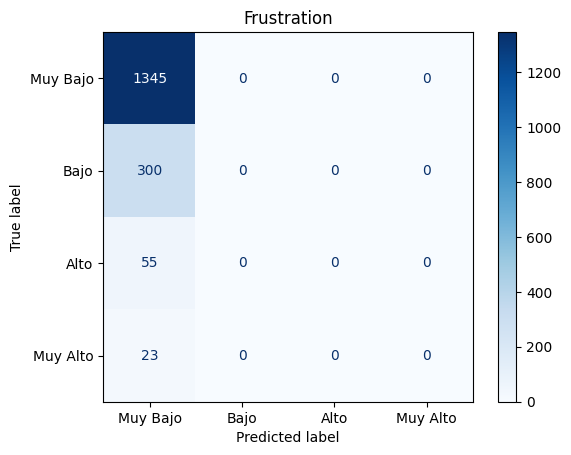

In [90]:
# Predecir
y_pred = model.predict(X_test)

# y_pred es una lista: [boredom, engagement, confusion, frustration]
pred_boredom = np.argmax(y_pred[0], axis=1)
pred_engagement = np.argmax(y_pred[1], axis=1)
pred_confusion = np.argmax(y_pred[2], axis=1)
pred_frustration = np.argmax(y_pred[3], axis=1)

true_boredom = np.argmax(y_boredom_test, axis=1)
true_engagement = np.argmax(y_engagement_test, axis=1)
true_confusion = np.argmax(y_confusion_test, axis=1)
true_frustration = np.argmax(y_frustration_test, axis=1)

# Función para graficar
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Muy Bajo", "Bajo", "Alto", "Muy Alto"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Dibujar las 4 matrices
plot_confusion_matrix(true_boredom, pred_boredom, "Boredom")
plot_confusion_matrix(true_engagement, pred_engagement, "Engagement")
plot_confusion_matrix(true_confusion, pred_confusion, "Confusion")
plot_confusion_matrix(true_frustration, pred_frustration, "Frustration")

In [91]:
from sklearn.metrics import classification_report

def evaluar_emocion(y_true, y_pred, nombre_emocion):
    print(f"Evaluación para {nombre_emocion}:")
    print(classification_report(
        y_true, 
        y_pred, 
        labels=[0,1,2,3],
        target_names=["Muy Bajo", "Bajo", "Alto", "Muy Alto"]
    ))
    print("-" * 50)

# Para cada emoción:
evaluar_emocion(true_boredom, pred_boredom, "Boredom")
evaluar_emocion(true_engagement, pred_engagement, "Engagement")
evaluar_emocion(true_confusion, pred_confusion, "Confusion")
evaluar_emocion(true_frustration, pred_frustration, "Frustration")

Evaluación para Boredom:
              precision    recall  f1-score   support

    Muy Bajo       0.50      0.73      0.59       801
        Bajo       0.37      0.24      0.29       548
        Alto       0.29      0.15      0.20       337
    Muy Alto       0.00      0.00      0.00        37

    accuracy                           0.45      1723
   macro avg       0.29      0.28      0.27      1723
weighted avg       0.40      0.45      0.41      1723

--------------------------------------------------
Evaluación para Engagement:
              precision    recall  f1-score   support

    Muy Bajo       0.00      0.00      0.00         4
        Bajo       0.00      0.00      0.00        81
        Alto       0.53      0.78      0.63       861
    Muy Alto       0.52      0.29      0.37       777

    accuracy                           0.52      1723
   macro avg       0.26      0.27      0.25      1723
weighted avg       0.50      0.52      0.48      1723

--------------------------